# Jamboree 
has helped thousands of students make it to top colleges abroad. Be it GMAT, GRE or SAT, their unique problem-solving methods ensure maximum scores with minimum effort. They recently launched a feature where students/learners can come to their website and check their probability of getting into the IVY league college. This feature estimates the chances of graduate admission from an Indian perspective.

## Problem Statement:
1. To understand what factors are important in graduate admissions and how these factors are interrelated among themselves
2. To predict one's chances of admission, given the rest of the variables

In [1]:
# Importing required packages for analysis 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# Importing stats functions 
from scipy.stats import chi2_contingency,ttest_ind,levene,f_oneway,mannwhitneyu,pearsonr,spearmanr,kruskal,normaltest

In [3]:
# Importing ML related functions 
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold,GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
import statsmodels.api as sm

In [4]:
# Initial pandas & matplotlib setup 
pd.options.display.max_rows = 30
pd.options.display.max_columns = 30
np.set_printoptions(precision=2,suppress=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# To increase jupyter notebook cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
# To plot clear graphs 
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [7]:
# Importing the given dataset to pandas dataframe 
data = pd.read_csv("./Data/Admission.csv")
data.drop(columns="Serial No.",inplace=True)
df = data.copy()
df.head(5)

GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research  \
0        337          118                  4  4.5   4.5  9.65         1   
1        324          107                  4  4.0   4.5  8.87         1   
2        316          104                  3  3.0   3.5  8.00         1   
3        322          110                  3  3.5   2.5  8.67         1   
4        314          103                  2  2.0   3.0  8.21         0   

   Chance of Admit   
0              0.92  
1              0.76  
2              0.72  
3              0.80  
4              0.65

### Column Profiling:

1. Serial No. (Unique row ID)
2. GRE Scores (out of 340)
3. TOEFL Scores (out of 120)
4. University Rating (out of 5)
5. Statement of Purpose and Letter of Recommendation Strength (out of 5)
6. Undergraduate GPA (out of 10)
7. Research Experience (either 0 or 1)
8. Chance of Admit (ranging from 0 to 1)

In [8]:
# To get the shape of the dataset 
print(f"Number of records : {df.shape[0]}")
print(f"Total Features:  {df.shape[1]}")

Number of records : 500
Total Features:  8


In [9]:
# Check for duplicates 
df.loc[df.duplicated(),:]

Empty DataFrame
Columns: [GRE Score, TOEFL Score, University Rating, SOP, LOR , CGPA, Research, Chance of Admit ]
Index: []

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


### Insights:
1. There are 500 records with 8 different columns sans Serial No. 
2. There are no duplicates or missing values in any of the columns 
3. Datatypes of Research, and University Rating can be changed to object for analysis 

In [11]:
# Remove unwanted spaces and rename the column & index names to make analysis easier 
df.columns = ["_".join(col.strip().split(" ")) for col in df.columns]
df.columns

Index(['GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance_of_Admit'],
      dtype='object')

In [12]:
# Change datatype of Research, and University Rating columns
df["University_Rating"] = df["University_Rating"].astype("object")
df["Research"] = df["Research"].astype("object")

In [14]:
# Create two lists of Categorical & Numerical features 
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=["int","float"]).columns.tolist()

print(f"Categorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")

Categorical Columns: ['University_Rating', 'Research']
Numerical Columns: ['GRE_Score', 'TOEFL_Score', 'SOP', 'LOR', 'CGPA', 'Chance_of_Admit']


In [15]:
df.describe()

GRE_Score  TOEFL_Score         SOP        LOR        CGPA  \
count  500.000000   500.000000  500.000000  500.00000  500.000000   
mean   316.472000   107.192000    3.374000    3.48400    8.576440   
std     11.295148     6.081868    0.991004    0.92545    0.604813   
min    290.000000    92.000000    1.000000    1.00000    6.800000   
25%    308.000000   103.000000    2.500000    3.00000    8.127500   
50%    317.000000   107.000000    3.500000    3.50000    8.560000   
75%    325.000000   112.000000    4.000000    4.00000    9.040000   
max    340.000000   120.000000    5.000000    5.00000    9.920000   

       Chance_of_Admit  
count        500.00000  
mean           0.72174  
std            0.14114  
min            0.34000  
25%            0.63000  
50%            0.72000  
75%            0.82000  
max            0.97000

### Insights:
1. Based on mean & median values of above columns, it doesn't look like there are many outliers 
2. Also, data seem to comply with the ranges provided in column profiling 

In [16]:
def print_unique_values_and_counts(cols_list,df):
    
    """
    Given a list of columns & dataframe, print unique values and counts 
    
    """
    print("Unique Values & Unique Value Counts:")
    print()
    
    for column in cols_list:
        print(f"{column} :\n Unique Values: {df[column].unique()},\n Unique Value Counts: {df[column].nunique()}")
        print("----------------------------XXX----------------------------")
        print()
    
    return 

# Calling the above function with categorical columns list & data 
print_unique_values_and_counts(cat_cols,df)

Unique Values & Unique Value Counts:

University_Rating :
 Unique Values: [4 3 2 5 1],
 Unique Value Counts: 5
----------------------------XXX----------------------------

Research :
 Unique Values: [1 0],
 Unique Value Counts: 2
----------------------------XXX----------------------------



### Insights:
1. Unique values of University_Rating & Research match with ranges provided in column profiling

In [17]:
def print_value_counts(cols_list):
    
    """
    Given list of columns, counts of first 10 different categories 
    
    """
    for col in cols_list:
        print(col,":")
        print()
        print(df.loc[:,col].value_counts().head(10))
        print()
        print("----------------------------XXX----------------------------")
        print()
        
    return 
# Call above function with the list of categorical columns 
print_value_counts(cat_cols)

University_Rating :

University_Rating
3    162
2    126
4    105
5     73
1     34
Name: count, dtype: int64

----------------------------XXX----------------------------

Research :

Research
1    280
0    220
Name: count, dtype: int64

----------------------------XXX----------------------------



### Insights:
1. There are more students from universities with University_Rating 3, closely followed by students from Univesity_Rating 2
2. More than 50% of students are/were doing research

In [18]:
from math import inf 
def calculate_quartiles(df,column,unit= None,minCap=-inf,):
    
    """
    Given a dataframe and numerical column, calculate quartiles, IQR 
    
    """
    quartile1 = np.percentile(df[column],25)
    quartile3 = np.percentile(df[column],75)
    IQR = quartile3-quartile1 
    minimum = max(quartile1-1.5*IQR,minCap)
    maximum = quartile3+1.5*IQR
    
    print(f"Quartile 1:  {unit}{quartile1}")
    print(f"Quartile 3:  {unit}{quartile3}")
    print(f"IQR (Inter Quartile Range): {unit}{np.round(quartile3-quartile1)}")
    print(f"Minimum {column}: {unit}{minimum}\nMaximum {column}: {unit}{maximum}")
    
    return minimum, maximum

In [19]:
# Calculating the quartiles and percentage of outliers 

for column in num_cols:
    print(f"{column}:")
    print()
    lower_limit, upper_limit = calculate_quartiles(df,column,unit='',minCap= 0)
    
    outliers = df.loc[(df[column] > upper_limit) | (df[column] < lower_limit),column]
    outliers_percentage = outliers.shape[0]*100/df[column].shape[0]
    
    print(f"Total count of Outliers: {outliers.shape[0]} out of {df.shape[0]} records")
    print(f"Percentage of Outliers in the dataset: {np.round(outliers_percentage,2)}%")
    
    print()
    print("----------------------------XXX----------------------------")
    print()
    

GRE_Score:

Quartile 1:  308.0
Quartile 3:  325.0
IQR (Inter Quartile Range): 17.0
Minimum GRE_Score: 282.5
Maximum GRE_Score: 350.5
Total count of Outliers: 0 out of 500 records
Percentage of Outliers in the dataset: 0.0%

----------------------------XXX----------------------------

TOEFL_Score:

Quartile 1:  103.0
Quartile 3:  112.0
IQR (Inter Quartile Range): 9.0
Minimum TOEFL_Score: 89.5
Maximum TOEFL_Score: 125.5
Total count of Outliers: 0 out of 500 records
Percentage of Outliers in the dataset: 0.0%

----------------------------XXX----------------------------

SOP:

Quartile 1:  2.5
Quartile 3:  4.0
IQR (Inter Quartile Range): 2.0
Minimum SOP: 0.25
Maximum SOP: 6.25
Total count of Outliers: 0 out of 500 records
Percentage of Outliers in the dataset: 0.0%

----------------------------XXX----------------------------

LOR:

Quartile 1:  3.0
Quartile 3:  4.0
IQR (Inter Quartile Range): 1.0
Minimum LOR: 1.5
Maximum LOR: 5.5
Total count of Outliers: 1 out of 500 records
Percentage of 

### Insights:
1. Outliers exist in Chance_of_Admit, and LOR columns but very small percentage. 
2. Other columns do not have any outliers 

## Visual Analysis:

### Univariate Analysis:

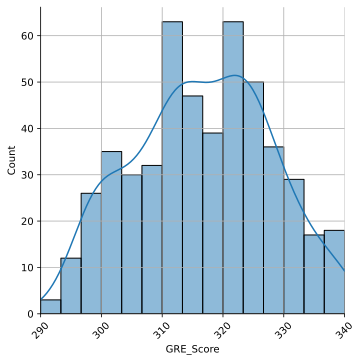

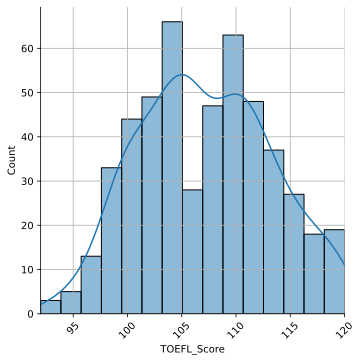

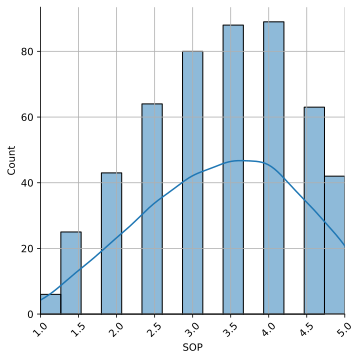

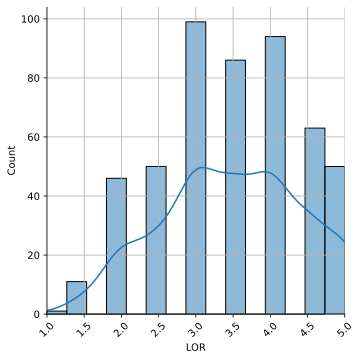

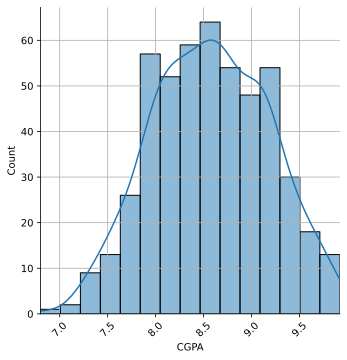

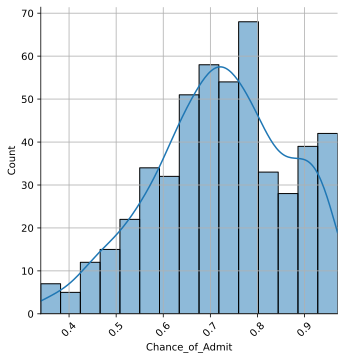

In [20]:
# To plot the Kernel density distribution and histogram of numerical columns 
for column in num_cols:
    sns.displot(df[column],kde=True,bins = 15)
    plt.xlim((df[column].min(),df[column].max()))
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

### Insights:
1. GRE_Score & TOEFL_Score have bimodal distributions
2. CGPS is close to Guassian. Rest of them including Chance_of_Admit, are left skewed.

In [21]:
def print_count_plots(df,cols_list,limit=50):
    
    """
    Given the dataframe, categorical columns list, returns the count plots for all 
    Caveat: If there are more than 100 unique categories for a column, it is skipped 
    
    """
    for col in cat_cols:
        if df[col].nunique() <= limit:
            sns.countplot(data=df,x=col,order=df[col].value_counts().index)
            plt.show()
    
    return 

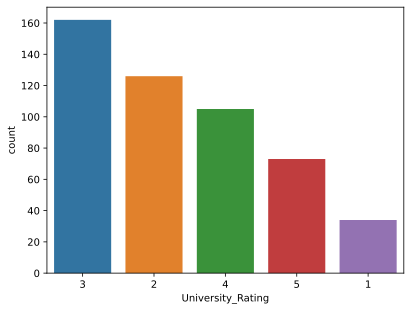

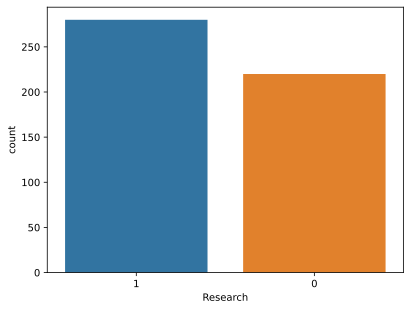

In [23]:
# To generate count plots for all categorical variables 
print_count_plots(df,cat_cols)

### Insights:
1. As seen earlier, there are more students from universities with University_Rating of 3
2. More than 50% students have research experience

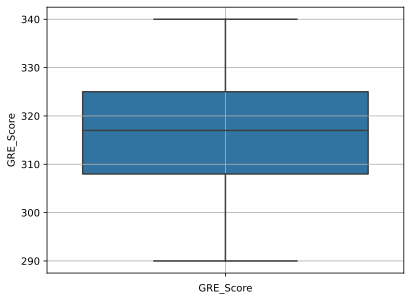

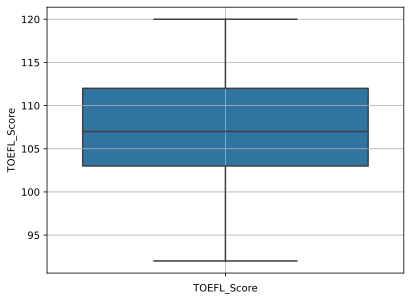

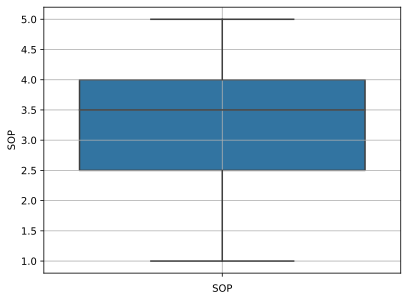

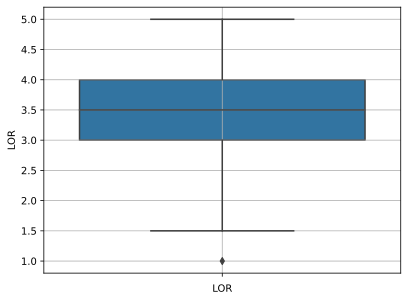

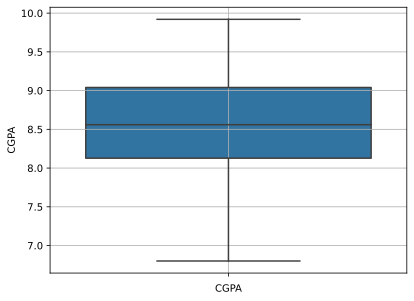

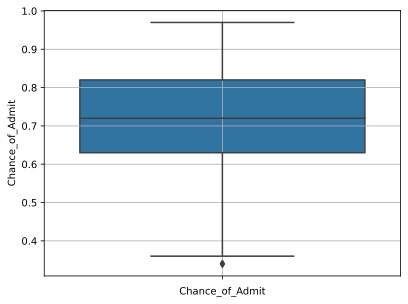

In [24]:
# Generate box plots for all numerical columns 
for column in num_cols:
    sns.boxplot(data=df,y=column)
    plt.xlabel(column)
    plt.grid(True)
    plt.show()

### Insights:
1. Median SOP, LOR scores are 3.5.Median GRE_Score & TOEFL_Score ~318, ~107 respectively 
2. 50% of students have Chance_of_Admit between ~0.6 to ~0.8 

### Bivariate Analysis:

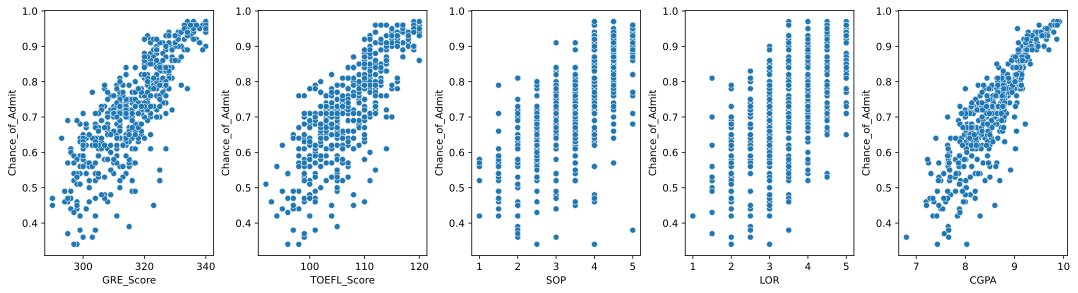

In [38]:
fig,axes = plt.subplots(nrows=1,ncols=len(num_cols)-1,figsize=(15,4))
fig.tight_layout(h_pad=3)

for i,col in enumerate(num_cols):
    
    if col != "Chance_of_Admit":
        sns.scatterplot(x=df[col], y=df["Chance_of_Admit"],ax= axes[i])

plt.show()


### Insights:
1. TOEFL_Score, GRE_Score, CGPA seem to have a positive correlaton with Chance_of_Admit 
2. As SOP & LOR rating increase, chances of admit range seem to increase. However, not as correlated as other features
3. TOEFL_Score, GRE_Score, and CGPA seem to be positively correlated as well

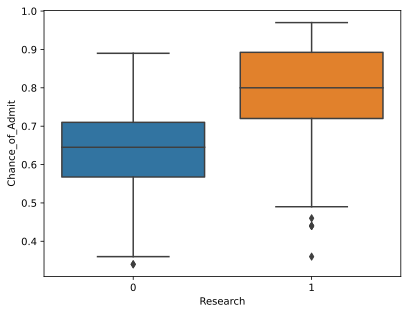

In [26]:
# Plot boxplot 
sns.boxplot(x=df["Research"],y=df["Chance_of_Admit"])
plt.show()

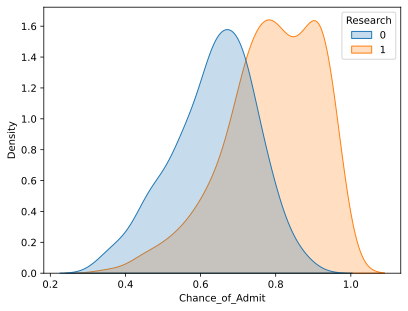

In [27]:
sns.kdeplot(hue=df["Research"],x=df["Chance_of_Admit"],fill=True)
plt.show()

#### Insights:
1. Median Chance of Admit is higher for students with research experience when compared to students without research experience 
2. Chance_of_Admit distribution for students, with research experience, is slighlty towards right of that of students without research experience. Is it significant is something to check as part of inferencial analysis

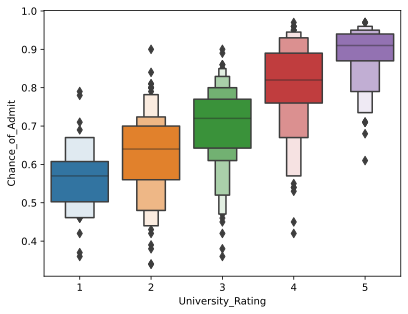

In [28]:
# Plot boxplot 
sns.boxenplot(x=df["University_Rating"],y=df["Chance_of_Admit"])
plt.show()

#### Insights:
1. Median Chance of Admit is higher for students from better universities. There are some exceptions however 
2. Chance_of_Admit distributions overlap for students from different university ratings. Greater the rating, more left skewed the distributions
3. Is there significant difference in mean/median Chance_of_Admit ? - to check as part of inferencial analysis

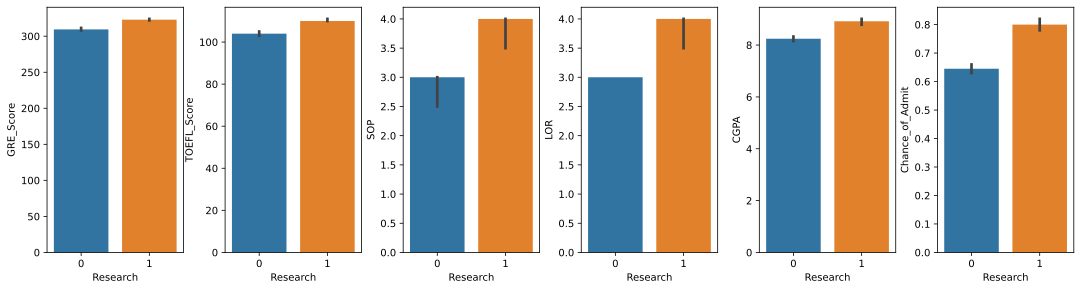

In [29]:
fig,axes = plt.subplots(nrows=1,ncols=6,figsize=(15,4))
fig.tight_layout(h_pad=3)

for i,col in enumerate(num_cols):
    sns.barplot(x=df["Research"],y=df[col],n_boot=1000,errorbar=('ci',95),ax=axes[i],estimator="median")
plt.show() 

#### Insights:
1. Estimated Median SOP, LOR, Chance of Admit of students with research experience is higher than their counterpart
2. For GRE_Score, TOEFL_Score, and CGPA - Difference of estimated median is lower 

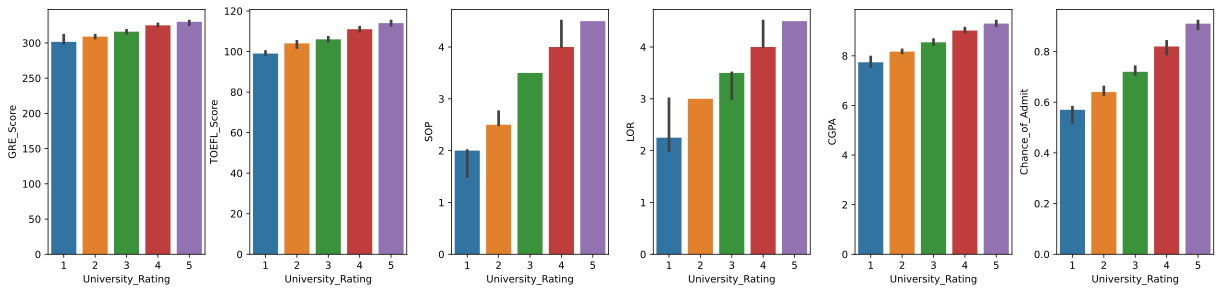

In [39]:
fig,axes = plt.subplots(nrows=1,ncols=6,figsize=(17,4))
fig.tight_layout(h_pad=3)

for i,col in enumerate(num_cols):
    sns.barplot(x=df["University_Rating"],y=df[col],n_boot=1000,errorbar=('ci',95),ax=axes[i],estimator="median")
plt.show() 

#### Insights:
1. Estimated Median SOP,LOR,CGPA, and Chance_of_Admit values of students from highly rated universities are higher 
2. Estimated Median GRE_Score, TOEFL_Score are only slighly higher for students from universities of high rating

### Multivariate Analysis:

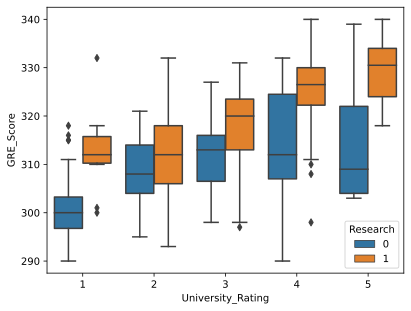

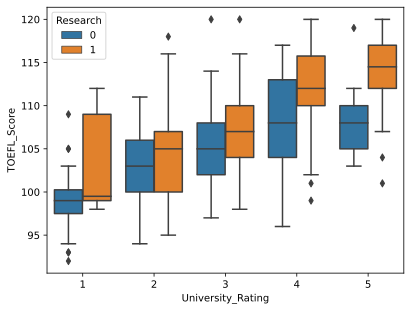

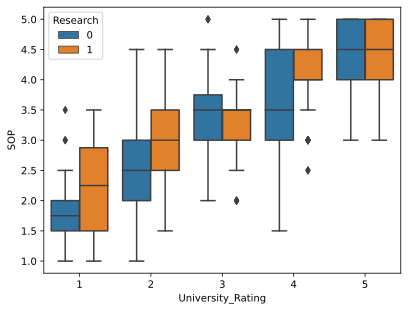

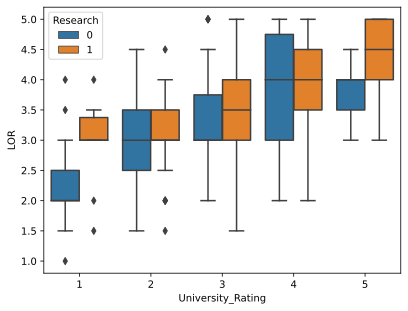

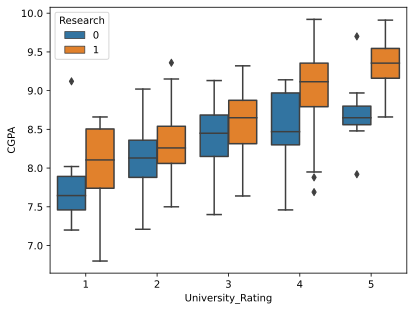

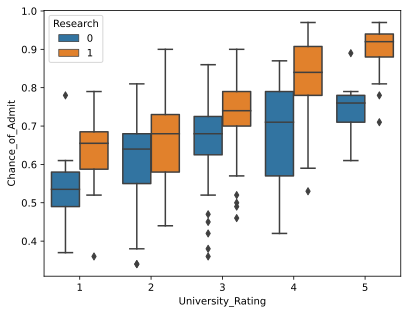

In [40]:
# Plot boxplot 
for col in num_cols:
    sns.boxplot(x=df["University_Rating"],y=df[col],hue=df["Research"])
    plt.show()

#### Insights:
1. Regardless of the University_Rating, students with research experience seem to have higher median TOEFL_Score,GRE_Score, and Chance_of_Admit than their counterparts
2. Above holds true for SOP, and LOR scores as well with some exceptions. 
    * Median SOP scores of students with research experience of University_Rating 3 is lesser than their counterparts
    * Median SOP scores of students with research experience of University_Rating 5 is equal to that of students without research experience
3. Median LOR score of students with experience (University_Rating 4) is equal to that of students without research experience

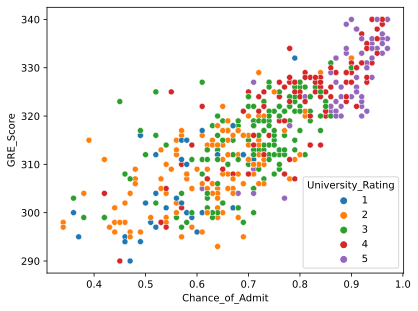

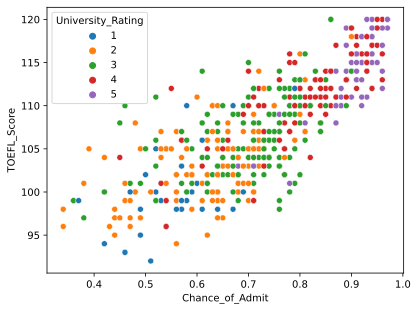

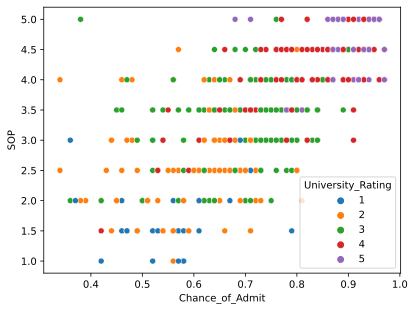

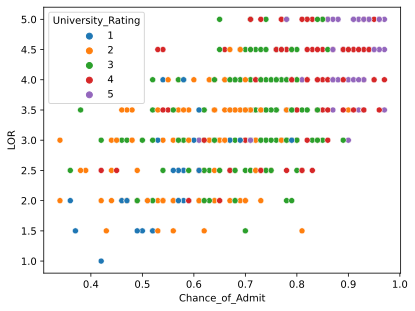

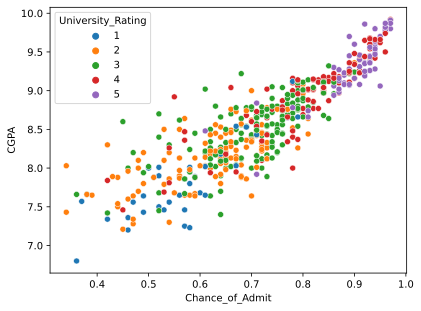

In [41]:
for col in num_cols:
    if col != "Chance_of_Admit":
        sns.scatterplot(y=df[col], x=df["Chance_of_Admit"],hue=df["University_Rating"],palette=sns.color_palette(n_colors=5))
        plt.show()

#### Insights:
1. As expected, majority of students, from high rating universities, are on higher end of the spectrum in all scores

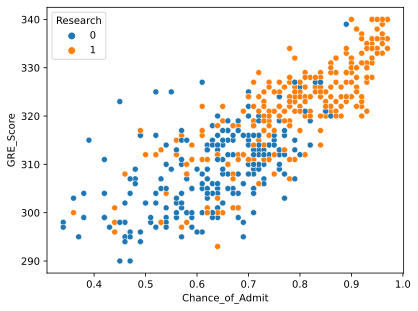

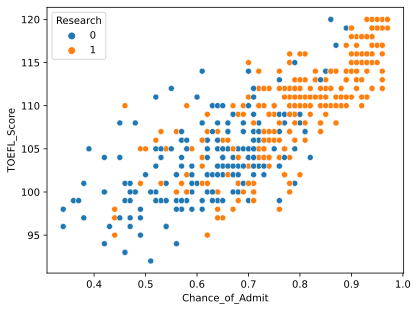

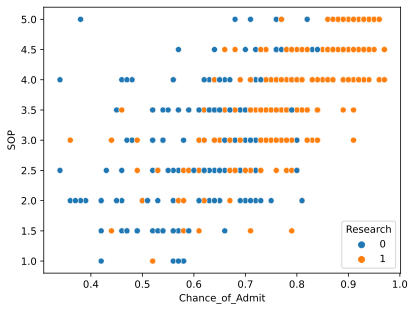

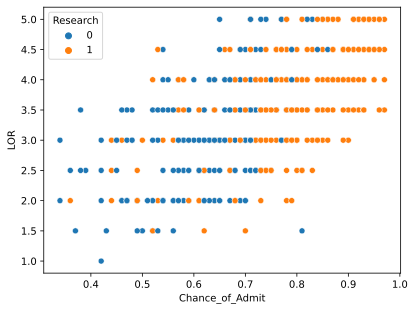

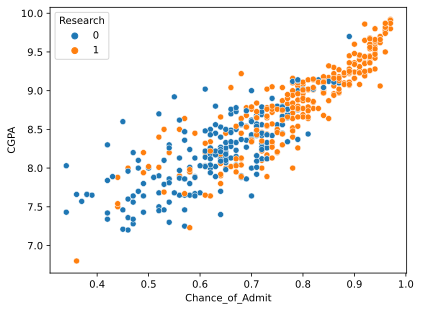

In [42]:
for col in num_cols:
    if col != "Chance_of_Admit":
        sns.scatterplot(y=df[col], x=df["Chance_of_Admit"],hue=df["Research"],palette=sns.color_palette(n_colors=2))
        plt.show()

#### Insights:
1. As expected, majority of research experienced students are on higher end of the spectrum in all scores

In [46]:
# To see how features relate with other features 
sns.pairplot(df.drop(columns=["Chance_of_Admit"]))
plt.show()

#### Insights:
1. Higher CGPA students also have higher TOEFL_Score, GRE_Score and vice versa
2. However, there are student's CGPA, TOEFL_Score, and GRE_Score seem to vary even though they have similar SOP, LOR scores

### Correlation:

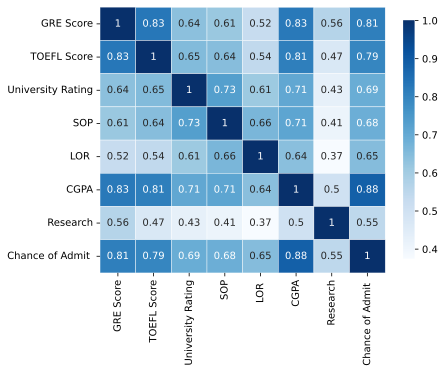

In [47]:
#Heatmap of correlation between different features:
sns.heatmap(data= data.corr(method="pearson",numeric_only=True)
            ,cbar_kws={"shrink": .9},linewidths=0.4,cmap="Blues",annot=True,
           )
plt.yticks(rotation = 0)
plt.show()

#### Insights:
1. Evidently, features are highly correlated with Chance of Admit as well as with each other
2. CGPA, and GRE_Score are highly correlated features with Chance of Admit. Closely followed by TOEFL_Score
3. GRE_Score, TOEFL_Score, and CGPA has correlation of above 0.8
4. There is a possiblity of multi-collinearity in the features as well

### Inferential Stats:

Based on the exploratory data analysis, here are couple of hypothesis to see if same can be inferred about the population:
1. Are research & University_Ratings associated ?
2. Students with research experience, regardless of their university rating, have higher mean/median TOEFL, GRE scores, CGPA, Chance_of_Admit compared to their counterparts ?
3. Are mean/median GRE, TOEFL scores, CGPA, LOR, SOP of students, from different university rating, are different ?

#### Hypothesis 1: Are research & University_Ratings associated ?

In [48]:
# More Students from Universities with ratings 3 & above, seem to have research experience 
# Lets see if this association is significant using chi2_contingency 
pd.crosstab(index=df["Research"],columns= df["University_Rating"],margins=True,normalize="columns")

University_Rating         1         2         3         4         5   All
Research                                                                 
0                  0.705882  0.706349  0.462963  0.219048  0.123288  0.44
1                  0.294118  0.293651  0.537037  0.780952  0.876712  0.56

In [49]:
# Assumptios: 
# All assumptions related to Chisquare are met. 
# Mutually exclusive, two categorical variables, and more than 5 frequency in each group

# Null Hypothesis H0: There is no association between Research and University_Rating 
# Alternate Hypothesis Ha: There is association between Research and University_Rating 

chi2_contingency(pd.crosstab(index=df["Research"],columns= df["University_Rating"]))

Chi2ContingencyResult(statistic=96.90000948490646, pvalue=4.4936229585994394e-20, dof=4, expected_freq=array([[14.96, 55.44, 71.28, 46.2 , 32.12],
       [19.04, 70.56, 90.72, 58.8 , 40.88]]))

#### Insights:
1. With significance level of 0.05, we have enough evidence to reject H0 and accept Ha - Research & University_Rating are associated

In [50]:
def check_normality(data, alpha = 0.05):
    
    # Null Hypothesis, H0: Given data comes from normal distribution  
    # Alternate Hypothesis, Ha: Given data does not come normal distribution
    
    from scipy.stats import normaltest

    teststatistic, pvalue = normaltest(data)
    
#     print("Null Hypothesis, H0: Given data comes from normal distribution")
#     print("Alternate Hypothesis, Ha: Given data does not come from normal distribution")
    
    print("Result: ", end=" ")
    if pvalue < alpha:
        print("Reject H0. Therefore, Given data does not come normal distribution")
    else:
        print("Unable to reject H0. Therefore, Given data comes from normal distribution")
        
#     print()
#     print("----------------------------XXX----------------------------")
#     print()
    
    print("Hypothesis test performed: ", normaltest.__name__)
    print(f"TestStatistic:{np.round(teststatistic,4)}, Pvalue:{np.round(pvalue,4)}")
    

In [51]:
def check_equal_variance(*samples, normality = True, alpha=0.05):
    
    # Null Hypothesis, H0:  samples come from populations with equal variances 
    # Alternate Hypothesis, Ha: samples do NOT come from populations with equal variances 
    
    from scipy.stats import levene
    
#   ‘median’: recommended for skewed distributions.
#   ‘mean’: recommended for symmetric, moderate-tailed distributions.
#   ‘trimmed’: recommended for heavy-tailed distributions.
    
    if normality:
        center = "mean"
    else:
        center = "median"

    teststatistic, pvalue = levene(*samples,center = center)
    

#     print("Null Hypothesis, H0:  samples come from populations with equal variances ")
#     print("Alternate Hypothesis, Ha: samples do NOT come from populations with equal variances ")
    
    
    print("Result: ", end=" ")
    if pvalue < alpha:
        print("Reject H0. Samples do NOT come from populations with equal variances")
    else:
        print("Unable to reject H0. Therefore,samples come from populations with equal variances")
        
#     print()
#     print("----------------------------XXX----------------------------")
#     print()
    
    print("Hypothesis test performed: ", levene.__name__)
    print(f"TestStatistic:{np.round(teststatistic,4)}, Pvalue:{np.round(pvalue,4)}")
    

In [52]:
def compare_two_means(sample1, sample2, normality = True, equal_var = True, alpha = 0.05, alternative = "greater"):
    
    '''
    Conducts ttest_ind or mannwhitneyu test based on normality and variance of the samples 
    By providing alternative value, either one sided or two sided test can be conducted 
    
    '''

    if alternative not in ["two-sided","less","greater"]:
        print("selected alternative is incorrect")
        return    
    
    from scipy.stats import ttest_ind, mannwhitneyu
    
            
    if normality and equal_var:
        func = ttest_ind
    else:
        func = mannwhitneyu
        
    
    teststatistic, pvalue = func(sample1, sample2, alternative = alternative)
    
    if alternative == "greater":
        
#         print("Null Hypothesis,H0: sample1 mean/median (mu1) <= sample2 mean/median (mu2)") 
#         print("Alternate Hypothesis,Ha: mu1 > mu2")
        
        print("Result: ", end=" ")
        if pvalue < alpha:
            print("Reject H0. mu1 > mu2")
        else:
            print("Unable to reject H0, mu1 <= mu2")
                  
    print("Hypothesis test performed: ", func.__name__)
    print(f"TestStatistic:{np.round(teststatistic,4)}, Pvalue:{np.round(pvalue,4)}")

#### Hypothesis 2: Students with research experience, regardless of their university rating, have higher mean/median TOEFL, GRE scores, CGPA compared to their counterparts ?

In [53]:
# Split the data into two. Research & Non-Research students 
cond = (df["Research"] == 1)
research = df.loc[cond,:]
non_research = df.loc[~(cond),:]

#### Test Assumptions of Normality, Equal Variance before proceeding with above Hypothesis test:
#### Test for Normality:

* Null Hypothesis, H0:  samples come from populations with equal variances 
* Alternate Hypothesis, Ha: samples do NOT come from populations with equal variances 

In [54]:
for col in num_cols:
    print(f"{col}:")
    check_normality(research[col])
    print("------------------XXXX--------------------")

GRE_Score:
Result:  Reject H0. Therefore, Given data does not come normal distribution
Hypothesis test performed:  normaltest
TestStatistic:12.2635, Pvalue:0.0022
------------------XXXX--------------------
TOEFL_Score:
Result:  Reject H0. Therefore, Given data does not come normal distribution
Hypothesis test performed:  normaltest
TestStatistic:10.6977, Pvalue:0.0048
------------------XXXX--------------------
SOP:
Result:  Reject H0. Therefore, Given data does not come normal distribution
Hypothesis test performed:  normaltest
TestStatistic:11.7487, Pvalue:0.0028
------------------XXXX--------------------
LOR:
Result:  Reject H0. Therefore, Given data does not come normal distribution
Hypothesis test performed:  normaltest
TestStatistic:12.0061, Pvalue:0.0025
------------------XXXX--------------------
CGPA:
Result:  Reject H0. Therefore, Given data does not come normal distribution
Hypothesis test performed:  normaltest
TestStatistic:8.4713, Pvalue:0.0145
------------------XXXX-------

In [55]:
for col in num_cols:
    print(f"{col}:")
    check_normality(non_research[col])
    print("------------------XXXX--------------------")

GRE_Score:
Result:  Unable to reject H0. Therefore, Given data comes from normal distribution
Hypothesis test performed:  normaltest
TestStatistic:1.8814, Pvalue:0.3903
------------------XXXX--------------------
TOEFL_Score:
Result:  Unable to reject H0. Therefore, Given data comes from normal distribution
Hypothesis test performed:  normaltest
TestStatistic:5.1852, Pvalue:0.0748
------------------XXXX--------------------
SOP:
Result:  Reject H0. Therefore, Given data does not come normal distribution
Hypothesis test performed:  normaltest
TestStatistic:7.6444, Pvalue:0.0219
------------------XXXX--------------------
LOR:
Result:  Unable to reject H0. Therefore, Given data comes from normal distribution
Hypothesis test performed:  normaltest
TestStatistic:4.3074, Pvalue:0.1161
------------------XXXX--------------------
CGPA:
Result:  Unable to reject H0. Therefore, Given data comes from normal distribution
Hypothesis test performed:  normaltest
TestStatistic:1.275, Pvalue:0.5286
------

#### Test for equal variance:
* Null Hypothesis, H0:  samples come from populations with equal variances 
* Alternate Hypothesis, Ha: samples do NOT come from populations with equal variances 

In [56]:
for col in num_cols:
    print(f"{col}:")
    check_equal_variance(research[col],non_research[col],normality=False)
    print("------------------XXXX--------------------")

GRE_Score:
Result:  Unable to reject H0. Therefore,samples come from populations with equal variances
Hypothesis test performed:  levene
TestStatistic:1.1331, Pvalue:0.2876
------------------XXXX--------------------
TOEFL_Score:
Result:  Reject H0. Samples do NOT come from populations with equal variances
Hypothesis test performed:  levene
TestStatistic:9.2632, Pvalue:0.0025
------------------XXXX--------------------
SOP:
Result:  Unable to reject H0. Therefore,samples come from populations with equal variances
Hypothesis test performed:  levene
TestStatistic:1.3571, Pvalue:0.2446
------------------XXXX--------------------
LOR:
Result:  Unable to reject H0. Therefore,samples come from populations with equal variances
Hypothesis test performed:  levene
TestStatistic:0.0292, Pvalue:0.8645
------------------XXXX--------------------
CGPA:
Result:  Reject H0. Samples do NOT come from populations with equal variances
Hypothesis test performed:  levene
TestStatistic:7.8503, Pvalue:0.0053
----

#### Test to compare median/mean scores:
* Null Hypothesis,H0: sample1 mean/median (mu1) <= sample2 mean/median (mu2)
* Alternate Hypothesis,Ha: mu1 > mu2

In [57]:
for col in num_cols:
    print(f"{col}:")
    compare_two_means(research[col],non_research[col],normality=False,equal_var=False,alternative="greater")
    print("------------------XXXX--------------------")

GRE_Score:
Result:  Reject H0. mu1 > mu2
Hypothesis test performed:  mannwhitneyu
TestStatistic:51515.5, Pvalue:0.0
------------------XXXX--------------------
TOEFL_Score:
Result:  Reject H0. mu1 > mu2
Hypothesis test performed:  mannwhitneyu
TestStatistic:47777.0, Pvalue:0.0
------------------XXXX--------------------
SOP:
Result:  Reject H0. mu1 > mu2
Hypothesis test performed:  mannwhitneyu
TestStatistic:45303.0, Pvalue:0.0
------------------XXXX--------------------
LOR:
Result:  Reject H0. mu1 > mu2
Hypothesis test performed:  mannwhitneyu
TestStatistic:44111.0, Pvalue:0.0
------------------XXXX--------------------
CGPA:
Result:  Reject H0. mu1 > mu2
Hypothesis test performed:  mannwhitneyu
TestStatistic:49043.0, Pvalue:0.0
------------------XXXX--------------------
Chance_of_Admit:
Result:  Reject H0. mu1 > mu2
Hypothesis test performed:  mannwhitneyu
TestStatistic:51060.0, Pvalue:0.0
------------------XXXX--------------------


#### Insights:
1. Performed a non-parametric mannwhitneyu to compare median values of all features for students with research experience and without. 
2. With alpha as 0.05, it is evident that median scores of students with research experience is significantly higher than their counterparts 

#### Hypothesis Test 3: Mean/Median GRE, TOEFL scores, CGPA, LOR, SOP of students, from different university rating, are different ?

* Null Hypothesis,H0: All samples have same mean/median values
* Alternate Hypothesis,Ha: Atleast one sample have a different mean/median value

In [58]:
# Split the students based on their university ratings
university_students = {}
for i in sorted(df["University_Rating"].unique()):
    cond = (df["University_Rating"] == i)
    university_students[i] = df.loc[cond,:]

In [59]:
# Assuming that assumptions of Anova aren't met, perform non parametric Kruskal test
alpha = 0.05 
for col in num_cols:
    print(f"{col}:")
    teststatistic, pvalue =  kruskal(university_students[1][col],university_students[2][col],university_students[3][col],university_students[4][col],university_students[5][col])
    
    print("Result: ", end=" ")
    if pvalue > alpha:
        print(f"Students from differently rated universities, have same mean/median {col}")
    else:
        print(f"Students from differently rated universities, do not have same mean/median {col}. Atleast one is different")
                  
    print("Hypothesis test performed: ", kruskal.__name__)
    print(f"TestStatistic:{np.round(teststatistic,4)}, Pvalue:{np.round(pvalue,4)}")
    
    print("------------------XXXX--------------------")

GRE_Score:
Result:  Students from differently rated universities, do not have same mean/median GRE_Score. Atleast one is different
Hypothesis test performed:  kruskal
TestStatistic:208.7246, Pvalue:0.0
------------------XXXX--------------------
TOEFL_Score:
Result:  Students from differently rated universities, do not have same mean/median TOEFL_Score. Atleast one is different
Hypothesis test performed:  kruskal
TestStatistic:211.0893, Pvalue:0.0
------------------XXXX--------------------
SOP:
Result:  Students from differently rated universities, do not have same mean/median SOP. Atleast one is different
Hypothesis test performed:  kruskal
TestStatistic:266.8391, Pvalue:0.0
------------------XXXX--------------------
LOR:
Result:  Students from differently rated universities, do not have same mean/median LOR. Atleast one is different
Hypothesis test performed:  kruskal
TestStatistic:183.3783, Pvalue:0.0
------------------XXXX--------------------
CGPA:
Result:  Students from differently

#### Insights: 
1. Performed non-parametric Kruskal test to compare if mean/median scores & chances of admit  of students from different university rating are same
2. With significance level of 0.05, it is evident that scores & chances of admit are different  

### Data Preparation for Modelling:

In [74]:
def split_train_test(X,y,train_size=0.8,test_size=0.2):
    
    """
    Given features X and label y as dataframes, split them into train & test sets 
    and save them as two csv files. By default, train_size is set to 80%
    
    """
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=23)
    
    # Concat features & labels back
    train = pd.concat((X_train,y_train), axis=1)
    test = pd.concat((X_test,y_test), axis=1 )
    
    # Save the train & test set as separate csv files 
    train.to_csv("./Data/train.csv",index=False)
    test.to_csv("./Data/test.csv",index=False)
    
    return train, test 

In [68]:
def prepocessing(filePath):
    
    df = pd.read_csv(filepath_or_buffer=filePath)
    df = df.drop(columns="Serial No.")
    
    # Remove unwanted spaces and rename the column & index names to make analysis easier 
    df.columns = ["_".join(col.strip().split(" ")) for col in df.columns]
    df.to_csv(path_or_buf= "./Data/cleaned_data.csv", index=False)
    
    return df 

In [69]:
def create_kfolds(filePath,folds):
    
    """
    Given the filePath of the data, split the data into folds 
    based on the inputparameter folds. Saves the new dataframe as csv 
    
    """
    df = pd.read_csv(filepath_or_buffer= filePath)
    df["kfold"] =-1
    
    df = df.sample(frac=1,random_state=23).reset_index(drop=True)
    kf = KFold(n_splits = folds)
    
    for fold,(train_idx,valid_idx) in enumerate(kf.split(X=df)):
        df.loc[valid_idx,"kfold"] = fold
    
    df.to_csv("../input/train_folds.csv",index=False)

In [70]:
def create_skfolds(filePath,folds,label):
    
    """
    Uses binning on label column to split the data into multiple folds
    Note: Warns if folds are too high to bin the data correctly
    Also, saves the dataframe with new column folds as csv file
    
    """

    df = pd.read_csv(filepath_or_buffer= filePath )
    df["kfold"] =-1
    
    df = df.sample(frac=1,random_state=23).reset_index(drop=True)

    # Associate each datapoint to a bin
    df.loc[:,"bins"] = pd.cut(df[label], bins = folds, labels = False)
    
    kf = StratifiedKFold(n_splits = folds)
    
    for fold,(train_idx,valid_idx) in enumerate(kf.split(X=df,y=df["bins"].values)):
        df.loc[valid_idx,"kfold"] = fold
    
    df = df.drop(columns="bins")
    
    df.to_csv("../input/train_folds.csv",index=False)

### Building a simple Multivariate Linear Regression Model:

### Linear Regression:

In [71]:
# Drops Serial No. & fix the unwanted spaces in feature names 
# Saves the cleaned df 
df = prepocessing("./Data/Admission.csv")
df.head(5)

GRE_Score  TOEFL_Score  University_Rating  SOP  LOR  CGPA  Research  \
0        337          118                  4  4.5  4.5  9.65         1   
1        324          107                  4  4.0  4.5  8.87         1   
2        316          104                  3  3.0  3.5  8.00         1   
3        322          110                  3  3.5  2.5  8.67         1   
4        314          103                  2  2.0  3.0  8.21         0   

   Chance_of_Admit  
0             0.92  
1             0.76  
2             0.72  
3             0.80  
4             0.65

In [72]:
features = df.columns.drop("Chance_of_Admit").to_list()
label = "Chance_of_Admit"

print(f"Features: {features}")
print(f"Label: {label}")

Features: ['GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA', 'Research']
Label: Chance_of_Admit


In [75]:
# Split the data into train & test sets 
train, test = split_train_test(X=df[features],y=df[[label]])

In [76]:
# Separate features from the label of train set 

X_train = train[features]
y_train = train[[label]]

# Scale the train & valid set features 
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

In [77]:
# Add constant to the features 
scaled_X_train_with_constant = sm.add_constant(scaled_X_train)

In [78]:
# Fit the OLS model on training data 

model = sm.OLS(y_train,scaled_X_train_with_constant)
results = model.fit()

In [79]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Chance_of_Admit   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     255.5
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          8.73e-142
Time:                        18:10:07   Log-Likelihood:                 555.80
No. Observations:                 400   AIC:                            -1096.
Df Residuals:                     392   BIC:                            -1064.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7211      0.003    236.761      0.0

#### Insights:
1. R-squared & Adj. R-squared are ~0.8 and are close. Tells us that there are no unnecessary dimensions used in model building
2. Given that Prob (F-statistic) is very close to 0, suggest that there is a significant linear relationship between dependent and independent variables 
3. It doesn't matter if we scale or not scale the data as Oridnary Least Squares doesn't depend on gradient descent

In [80]:
# Predict the values for train data 
y_train_pred = results.predict(scaled_X_train_with_constant)

In [81]:
# Separate features & label for test dataset 
X_test = test[features]
y_test = test[[label]]

scaled_X_test = scaler.transform(X_test)

In [82]:
# Add constant to the features for intercept 
scaled_X_test_with_constant = sm.add_constant(scaled_X_test)

In [83]:
# Predict the values for test data 
y_test_pred = results.predict(scaled_X_test_with_constant)

In [84]:
# Showing actual Chance_of_Admit of test data & predicted y_test_hat side 
np.hstack((y_test.values, y_test_pred.reshape(-1,1)))[4:10]

array([[0.81, 0.77],
       [0.61, 0.79],
       [0.77, 0.76],
       [0.89, 0.85],
       [0.85, 0.83],
       [0.71, 0.74]])

### Model Performance Evaluation:

#### Training set: 

In [85]:
# Calculate R2square for train dataset 
r2_score(y_train,y_train_pred)

0.8202047364283864

In [86]:
# Calculate MAE for train dataset 
mean_absolute_error(y_train,y_train_pred)

0.04267592384199064

In [87]:
# Calculate Median Absolute Error for train dataset 
median_absolute_error(y_train,y_train_pred)

0.02898048447555407

In [88]:
# Calculate mean squared error for train dataset 
mean_squared_error(y_train,y_train_pred)

0.0036360165833867393

In [89]:
# Calculate root mean squared error for train dataset 
np.sqrt(mean_squared_error(y_train,y_train_pred))

0.06029939123562309

#### Test set:

In [90]:
# Calculate R2square for test dataset 
r2_score(y_test,y_test_pred)

0.8258557445209804

In [91]:
# Calculate MAE for test dataset 
mean_absolute_error(y_test,y_test_pred)

0.041332508041023085

In [92]:
# Calculate Median Absolute Error for test dataset 
median_absolute_error(y_test,y_test_pred)

0.029997657390810673

In [93]:
# Calculate mean squared error for test dataset 
mean_squared_error(y_test,y_test_pred)

0.003222128467196326

In [94]:
# Calculate root mean squared error for test dataset 
np.sqrt(mean_squared_error(y_test,y_test_pred))

0.05676379539104416

In [95]:
# Update the features names
weights = results.params
weights.index = ["const"] + features 
weights = np.round(weights,3)

# Parameters/Coefficients of the model 
weights

const                0.721
GRE_Score            0.021
TOEFL_Score          0.017
University_Rating    0.007
SOP                  0.003
LOR                  0.011
CGPA                 0.074
Research             0.010
dtype: float64

#### Insights:
1. Based on the weights associated with features, CGPA, GRE_Score seem to have higher weightage, followed by Research, TOEFL_Score, and LOR
2. R-squared for train & test sets are close to ~0.8 suggesting a decent fit 

### Test Assumptions for Linear Regression:

### Multicollinearity Check by VIF Score:

In [96]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [97]:
vif = pd.DataFrame()
X_t = scaled_X_train_with_constant[:,1:]
vif['Features'] = features
vif['VIF'] = [variance_inflation_factor(X_t, i) for i in range(X_t.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
5               CGPA  4.67
0          GRE_Score  4.42
1        TOEFL_Score  3.97
3                SOP  2.97
2  University_Rating  2.92
4                LOR  1.97
6           Research  1.50

#### Insights:
1. Features with VIF > 10 are considered to be very highly multicollinear. VIF value between 5 and 10 are considered to be highly collinear. 
2. In our set of features, CGPA & GRE_Score have VIF close to 5 but not > 5. Rest all features have VIF 4 and below. No high multicollinearity in the features 

### Mean of residuals is close to zero:

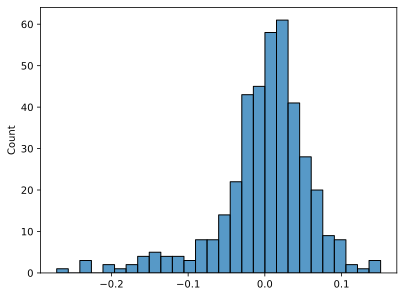

In [98]:
# Get the residuals of the above OLS regression model
residuals = results.resid

# Plot a density plot to view the distribution
sns.histplot(residuals)
plt.show()

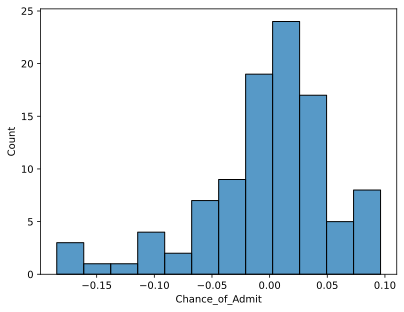

In [100]:
# Get the test data residuals 
test_residuals = test[label] - y_test_pred

# Plot a density plot to view the distribution
sns.histplot(test_residuals)
plt.show()

In [101]:
# Check the mean of the residuals 
round(np.mean(residuals),2)

-0.0

In [102]:
# Check the mean of the residuals 
round(np.mean(test_residuals),2)

-0.0

#### Insights:
1. Mean of the residuals of both training and test data is close to the zero. This assumption of Linear Regression holds true 

### Linearity of variables:

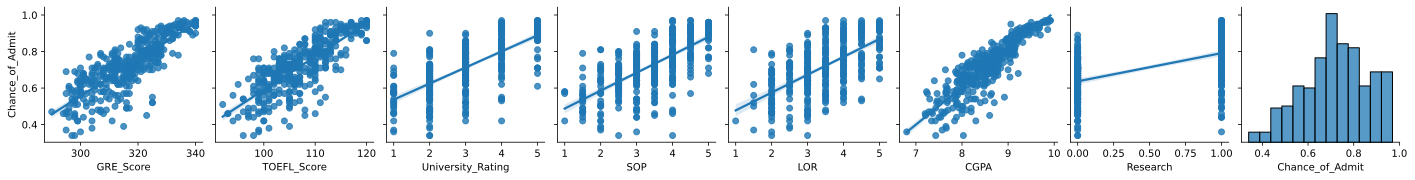

In [103]:
sns.pairplot(y_vars="Chance_of_Admit",data=train,kind="reg")
plt.show()

#### Insights:
1. As per the plots above, there exists a linear relationship between dependent and independent variables

### Test for Homoscedasticity:

#### Train Data:

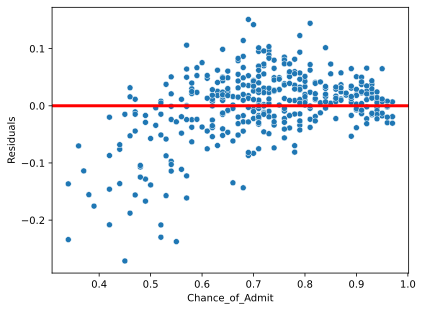

In [104]:
# Residuals plot od training data 
sns.scatterplot(x=train["Chance_of_Admit"].values,y=residuals.values)
plt.axhline(y=0,color ="red",linewidth=3)
plt.xlabel("Chance_of_Admit")
plt.ylabel("Residuals")
plt.show()

In [105]:
#H0: There is no heteroskedasticity in the residuals 
#Ha: There is no heteroskedasticity in the residuals 

from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals, scaled_X_train_with_constant)

# Extract the test statistics and p-values
test_statistic = bp_test[0]
p_value = bp_test[1]

# Print the test results
print("Breusch-Pagan Test:")
print("Test statistic:", test_statistic)
print("p-value:", p_value)

Breusch-Pagan Test:
Test statistic: 20.4624484856879
p-value: 0.00465281341145511


#### Test Data:

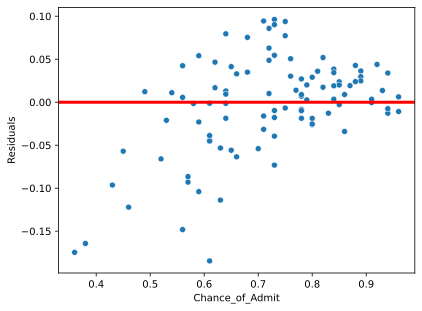

In [106]:
# Residuals plot of test data 
sns.scatterplot(x=test["Chance_of_Admit"].values,y=test_residuals.values)
plt.axhline(y=0,color ="red",linewidth=3)
plt.xlabel("Chance_of_Admit")
plt.ylabel("Residuals")
plt.show()

In [107]:
#H0: There is no heteroskedasticity in the residuals 
#Ha: There is no heteroskedasticity in the residuals 

from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(test_residuals, scaled_X_test_with_constant)

# Extract the test statistics and p-values
test_statistic = bp_test[0]
p_value = bp_test[1]

# Print the test results
print("Breusch-Pagan Test:")
print("Test statistic:", test_statistic)
print("p-value:", p_value)

Breusch-Pagan Test:
Test statistic: 16.86830894807262
p-value: 0.01826537347379551


#### Insights:
1. From the residuals plot & the above statisitical test, it is evident that there is heteroskedasticity in the residuals 
2. Could be because of left skewed Chance_of_Admit too
3. Tried different transformation for dependent variable & tried using weighted least sqares regression. But it didn't work

### Normality of residuals

In [108]:
# Null hypothesis H0: x comes from a normal distribution
# Alternate hypothesis Ha: x does not come from a normal distribution
alpha = 0.05

test_statistic, p_value = normaltest(residuals)
print(f"Test-statistic: {test_statistic}, p-value: {p_value}")

if p_value < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

Test-statistic: 103.53596929993317, p-value: 3.291924963275956e-23
The null hypothesis can be rejected


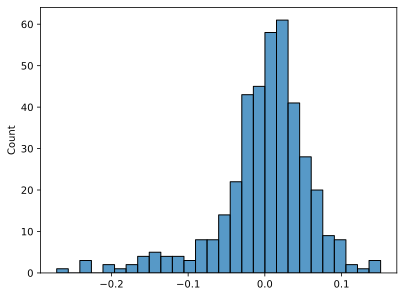

In [109]:
# plot the density plot for residuals 
sns.histplot(residuals)
plt.show()

#### Insights:
1. At significance level of 0.05, Residuals are not normally distributed. Skewed to the left like the label's distribution 
2. However, they are close to normal even though the normality test says otherwise

### Build a regularized model with cross validation

### Lasso/L1 Regression:

In [121]:
train = pd.read_csv("./Data/train.csv")
test  = pd.read_csv("./Data/test.csv")

In [126]:
# Create a pipeline that generates polynomial features, scales the data, and fits Lasso regressor 
model = Pipeline(steps = [("poly", PolynomialFeatures())
                         ,("scaler", StandardScaler())
                         ,("regressor", Lasso(max_iter=100000))]
                )

In [127]:
# Below are the hyperparameters for GridSearchCV
params = {"poly__degree" : np.arange(0,6)
         ,"regressor__alpha" : [0.0001,0.001,0.01,0.1,1,10,100,1000]
         }

In [128]:
# Get the GridSearchCV ready with scoring as "r2" and using KFold CV
search = GridSearchCV( estimator = model
            , param_grid = params
            , scoring= "r2"
            , n_jobs= -1
            , cv = KFold(n_splits=5,random_state=20,shuffle=True)
            , return_train_score= True       
            )

In [129]:
search.fit(train[features],train[[label]])

GridSearchCV(cv=KFold(n_splits=5, random_state=20, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('regressor', Lasso(max_iter=100000))]),
             n_jobs=-1,
             param_grid={'poly__degree': array([0, 1, 2, 3, 4, 5]),
                         'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                              100, 1000]},
             return_train_score=True, scoring='r2')

In [130]:
print(f"Best Hyperparameters: {search.best_params_}")
print(f"Best R2score on validation set: {np.round(search.best_score_,2)}")

Best Hyperparameters: {'poly__degree': 2, 'regressor__alpha': 0.001}
Best R2score on validation set: 0.81


In [131]:
# Using the hyperparameters above, train the model on entire training dataset 
model = Pipeline(steps = [("poly", PolynomialFeatures(degree=2))
                 ,("scaler", StandardScaler())
                 ,("regressor", Lasso(alpha =0.001 ,max_iter=1000))]
                 )

model.fit(X=train[features],y=train[[label]])

Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('regressor', Lasso(alpha=0.001))])

In [132]:
# R2score of model on training dataset 
y_train_pred = model.predict(train[features])
print(f" R2Score on train set: {np.round(r2_score(train[[label]],y_train_pred),2)}")

 R2Score on train set: 0.82


In [133]:
# Predict using the above model on test data 
y_test_pred = model.predict(test[features])
print(f"R2Score on test set: {np.round(r2_score(test[label],y_test_pred),2)}")

R2Score on test set: 0.83


### Model Performance Evaluation:

#### Training set:

In [134]:
# Calculate mean absolute error 
mean_absolute_error(train[label],y_train_pred)

0.04250095463370853

In [135]:
# Calculate median absolute error 
median_absolute_error(train[label],y_train_pred)

0.029538098609511787

In [136]:
# Calculate mean squared error
mse = mean_squared_error(train[label],y_train_pred)
mse 

0.0036007633644004554

In [137]:
# Calculate root mean squared error 
rmse = np.sqrt(mse)
rmse 

0.06000636103281431

#### Test set: 

In [138]:
# Calculate mean absolute error 
mean_absolute_error(test[label],y_test_pred)

0.04077021051733626

In [139]:
# Calculate median absolute error 
median_absolute_error(test[label],y_test_pred)

0.031015335724174364

In [140]:
# Calculate mean squarred error 
mse = mean_squared_error(test[label],y_test_pred)
mse 

0.0031777590795145456

In [141]:
# Calculate root mean squared error 
rmse = np.sqrt(mse)
rmse 

0.05637161590299276

#### Insights: 
1. Using CV & GridSearchCV, Hyperparameters found are alpha = 0.001, and degree = 2 with the best R2score on validation set as 0.82 
2. With those hyperparameters, trained the model on entire training data yielding R2score of 0.82 
3. On test dataset, R2score is 0.83. Also calcuated different metrics on training and test sets 

### Ridge/L2 Regularization:

In [142]:
# Create a pipiline that generates polynomial features, scales the data, and fits Ridge regressor 
model = Pipeline(steps = [("poly", PolynomialFeatures())
                 ,("scaler", StandardScaler())
                 ,("regressor", Ridge(max_iter=10000))]
                 )

In [143]:
# Below are the hyperparameters for GridSearchCV
params = {"poly__degree" : np.arange(0,6,1)
         ,"regressor__alpha" : [0.001,0.01,0.1,1,10,100,1000]
         }

In [144]:
# Get the GridSearchCV ready with scoring as "r2" and using KFold CV
search = GridSearchCV( estimator = model
            , param_grid = params
            , scoring= "r2"
            , n_jobs= -1
            , cv = KFold(n_splits=5,random_state=23,shuffle=True)
            , return_train_score= True       
                     )

In [145]:
search.fit(train[features],train[[label]])

GridSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('regressor', Ridge(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'poly__degree': array([0, 1, 2, 3, 4, 5]),
                         'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000]},
             return_train_score=True, scoring='r2')

In [146]:
print(f"Best Hyperparameters: {search.best_params_}")
print(f"Best R2score on validation set: {np.round(search.best_score_,2)}")

Best Hyperparameters: {'poly__degree': 2, 'regressor__alpha': 1}
Best R2score on validation set: 0.81


In [147]:
# Using the hyperparameters above, train the model on entire training dataset 
model = Pipeline(steps = [("poly", PolynomialFeatures(degree=2))
                 ,("scaler", StandardScaler())
                 ,("regressor", Ridge(alpha =1 ,max_iter=1000))]
                 )

In [148]:
model.fit(X=train[features],y=train[[label]])

Pipeline(steps=[('poly', PolynomialFeatures()), ('scaler', StandardScaler()),
                ('regressor', Ridge(alpha=1, max_iter=1000))])

In [149]:
# R2score of model on training dataset 
print(f" R2Score on train set: {np.round(r2_score(train[[label]],model.predict(train[features])),2)}")

 R2Score on train set: 0.83


In [150]:
# Predict using the above model on test data 
y_test_pred = model.predict(X=test[features])
print(f"R2Score on test set: {np.round(r2_score(test[label],y_test_pred),2)}")

R2Score on test set: 0.83


### Model Performance Evaluation:

#### Training set: 

In [151]:
# Predict on training data 
y_train_pred = model.predict(train[features])
y_train = train[label]

In [152]:
# Calculate R2square for train dataset 
r2_score(y_train,y_train_pred)

0.8297403320660772

In [153]:
# Calculate MAE for train dataset 
mean_absolute_error(y_train,y_train_pred)

0.04144482683522679

In [154]:
# Calculate Median Absolute Error for train dataset 
median_absolute_error(y_train,y_train_pred)

0.029790220700906866

In [155]:
# Calculate mean squared error for train dataset 
mean_squared_error(y_train,y_train_pred)

0.00344317733288388

In [156]:
# Calculate root mean squared error for train dataset 
np.sqrt(mean_squared_error(y_train,y_train_pred))

0.05867859348079059

#### Test set:

In [157]:
# Calculate r2_score
r2_score(test[label],y_test_pred,)

0.8327316736408757

In [158]:
# Calculate R2square for test dataset 
y_test = test[label]
r2_score(y_test,y_test_pred)

0.8327316736408757

In [159]:
# Calculate MAE for test dataset 
mean_absolute_error(y_test,y_test_pred)

0.04067237362711504

In [160]:
# Calculate Median Absolute Error for test dataset 
median_absolute_error(y_test,y_test_pred)

0.027533679130756994

In [161]:
# Calculate mean squared error for test dataset 
mean_squared_error(y_test,y_test_pred)

0.003094905626025386

In [162]:
# Calculate root mean squared error for test dataset 
np.sqrt(mean_squared_error(y_test,y_test_pred))

0.055631875988729575

#### Insights: 
1. Using CV & GridSearchCV, Hyperparameters found are alpha = 1, and degree = 2 with the best R2score on validation set as 0.81
2. With those hyperparameters, trained the model on entire training data yielding R2score of 0.83
3. On test dataset, R2score is 0.83. 

### WLS (Weighted Least Squares) 

In [163]:
# Separate features from the label of train set 

X_train = train[features]
y_train = train[[label]]

# Scale the train & valid set features 
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

# Add constant to the features 
scaled_X_train_with_constant = sm.add_constant(scaled_X_train)

In [164]:
# Fit the WLS model on training data 

model = sm.WLS(y_train,scaled_X_train_with_constant)
results = model.fit()

In [165]:
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:        Chance_of_Admit   R-squared:                       0.820
Model:                            WLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     255.5
Date:                Sun, 21 Apr 2024   Prob (F-statistic):          8.73e-142
Time:                        18:18:09   Log-Likelihood:                 555.80
No. Observations:                 400   AIC:                            -1096.
Df Residuals:                     392   BIC:                            -1064.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7211      0.003    236.761      0.0

In [166]:
# Predict the label values for train  data 
y_train_pred = results.predict(scaled_X_train_with_constant)

In [167]:
# Separate features & label for test dataset 
X_test = test[features]
y_test = test[[label]]

scaled_X_test = scaler.transform(X_test)

In [168]:
# Add constant to the features for intercept 
scaled_X_test_with_constant = sm.add_constant(scaled_X_test)

In [169]:
# Predict the values for test data 
y_test_pred = results.predict(scaled_X_test_with_constant)

In [170]:
# Showing actual Chance_of_Admit of test data & predicted y_test_hat side 
np.hstack((y_test.values, y_test_pred.reshape(-1,1)))[5:10]

array([[0.61, 0.79],
       [0.77, 0.76],
       [0.89, 0.85],
       [0.85, 0.83],
       [0.71, 0.74]])

In [171]:
# Calculate R2score for test data 
print(f"R2Score for test data: {np.round(r2_score(y_test,y_test_pred),2)}")

R2Score for test data: 0.83


### Model Performance Evaluation:

#### Training set: 

In [172]:
# Calculate R2square for train dataset 
r2_score(y_train,y_train_pred)

0.8202047364283864

In [173]:
# Calculate MAE for train dataset 
mean_absolute_error(y_train,y_train_pred)

0.04267592384199064

In [174]:
# Calculate Median Absolute Error for train dataset 
median_absolute_error(y_train,y_train_pred)

0.02898048447555407

In [175]:
# Calculate mean squared error for train dataset 
mean_squared_error(y_train,y_train_pred)

0.0036360165833867393

In [176]:
# Calculate root mean squared error for train dataset 
np.sqrt(mean_squared_error(y_train,y_train_pred))

0.06029939123562309

#### Test set:

In [177]:
# Calculate R2square for test dataset 
r2_score(y_test,y_test_pred)

0.8258557445209804

In [178]:
# Calculate MAE for test dataset 
mean_absolute_error(y_test,y_test_pred)

0.041332508041023085

In [179]:
# Calculate Median Absolute Error for test dataset 
median_absolute_error(y_test,y_test_pred)

0.029997657390810673

In [180]:
# Calculate mean squared error for test dataset 
mean_squared_error(y_test,y_test_pred)

0.003222128467196326

In [181]:
# Calculate root mean squared error for test dataset 
np.sqrt(mean_squared_error(y_test,y_test_pred))

0.05676379539104416

#### Insights: 
1. Regardless of using WLS, or GLS , couldn't get the R2score on test set above 0.83

### Final Insights:

1. CGPA, GRE Score, TOEFL Score have a very high correlation with Chance of Admit. Same can be inferred from the weights of the Linear Regression model as well
2. GRE Score, TOEFL Score are very highly correlated with CGPA 
3. Math Aptitude & English skills of students from higher rated universities seem to be better 
4. Students from university with higher rating, have better chances of admission into Ivy schools
5. Using Linear Regression with/without regularization, best perfomed model has an r2score of 0.83 -- improvement is required 

###  Inferences: 
1. Median GRE score, TOEFL Score, CGPA, LOR, SOP of students from universities with university ratings are different 
2. University rating & Research are associated. 
3. Students with research experience has higher median/mean CGPA, GRE Score, and TOEFL Scores. Their median chances of admission is also higher than that of students without experience

### Recommendations:

1. Recommend collecting more datapoints and balanced data to have more/better data for training
2. Collecting more datapoints like Years of work experience, Current Discipline, Targeted discipline at the Ivy School, Research papers published, IELTS Score, and others would help improve the model predictions
3. Recommend using different ML Models like Decision Trees to predict the Chances of admission - to improve model

### Potential Business Benefits:
1. Targeted ads for students with less/mediocre chances of admission into Ivy League. To enroll into Jamboree to improve GMAT/GRE/SAT Scores and increase their admission chances
2. As the model gets improved, it gives competitive edge to Jamboree over the competition and leads to more website traffic & enrollments 
